In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Constants
hbar = 1.0545718e-34  # Planck's constant / 2pi [J.s]
m_n = 1.675e-27  # Neutron mass [kg]
meV_to_Joules = 1.60218e-22  # meV to Joules conversion factor

final_energies = np.array([3.200, 3.382, 3.574, 3.787, 4.035, 4.312, 4.631, 4.987])  # Fixed final energies on CAMEA
# final_energies = np.array([4.987])  # Fixed final energies on CAMEA


In [38]:
def energy_to_wavevector(E):
    """Convert neutron energy (meV) to wavevector (1/Angstrom)."""
    E_joules = E * meV_to_Joules
    k = np.sqrt(2 * m_n * E_joules) / hbar
    return k * 1e-10  # Convert to 1/Angstrom

def rotation_matrix(theta):
    """Generate a 3D rotation matrix for a rotation by theta degrees around the z-axis."""
    theta_rad = np.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0],
        [np.sin(theta_rad), np.cos(theta_rad), 0],
        [0, 0, 1]
    ])

def calculate_reciprocal_lattice_vectors(a, b, c, alpha, beta, gamma):
    """Calculate reciprocal lattice vectors from lattice parameters."""
    alpha_rad, beta_rad, gamma_rad = np.radians([alpha, beta, gamma])
    volume = a * b * c * np.sqrt(1 - np.cos(alpha_rad)**2 - np.cos(beta_rad)**2 - np.cos(gamma_rad)**2 + 
                                 2 * np.cos(alpha_rad) * np.cos(beta_rad) * np.cos(gamma_rad))
    
    rlv_a = 2 * np.pi * np.array([b * c * np.sin(alpha_rad) / volume, 0, 0])
    rlv_b = 2 * np.pi * np.array([c * a * np.sin(beta_rad) * np.cos(gamma_rad) / volume,
                                  c * a * np.sin(beta_rad) * np.sin(gamma_rad) / volume, 0])
    rlv_c = 2 * np.pi * np.array([a * b * np.cos(beta_rad) * np.cos(alpha_rad) - a * b * np.cos(gamma_rad) * np.cos(alpha_rad),
                                  a * b * np.sin(alpha_rad), 
                                  a * b * np.sin(beta_rad) / volume])
    
    return np.array([rlv_a, rlv_b, rlv_c])

def calculate_lab_Q_E(E_i, E_f, detector_angle):
    """Calculate Q and Delta E in the laboratory coordinate system."""
    k_i = energy_to_wavevector(E_i)  # Incident wavevector magnitude
    k_f = energy_to_wavevector(E_f)  # Scattered wavevector magnitude

    # Detector angle converted to radians for calculations
    angle_rad = np.radians(detector_angle)

    # Final wavevector components in the lab frame
    k_f_x = k_f * np.cos(angle_rad)
    k_f_y = k_f * np.sin(angle_rad)
    k_f_z = 0  # Assuming the detector plane is in the x-y plane

    # Calculate the scattering vector Q = k_i - k_f
    Q_lab = np.array([k_i - k_f_x, -k_f_y, -k_f_z])

    # Calculate the energy transfer ΔE = E_i - E_f
    delta_E = E_i - E_f

    return Q_lab, delta_E

def convert_Q_to_sample_frame(Q_lab, theta_S, reciprocal_lattice_vectors):
    """Rotate Q according to sample rotation and convert to reciprocal lattice units."""
    # Create rotation matrix for the sample rotation
    rot_matrix = rotation_matrix(theta_S)

    # Rotate Q vector to account for the sample rotation
    Q_rotated = rot_matrix @ Q_lab

    # Convert Q from the lab frame to reciprocal lattice units (rlu)
    Q_rlu = np.linalg.inv(reciprocal_lattice_vectors) @ Q_rotated

    return Q_rlu


def calculate_reciprocal_lattice_vectors(a, b, c, alpha, beta, gamma):
    """Calculate the reciprocal lattice vectors based on lattice parameters."""
    # Convert angles from degrees to radians
    alpha_rad = np.radians(alpha)
    beta_rad = np.radians(beta)
    gamma_rad = np.radians(gamma)

    # Calculate volume of the unit cell
    volume = a * b * c * np.sqrt(1 - np.cos(alpha_rad)**2 - np.cos(beta_rad)**2 - np.cos(gamma_rad)**2 +
                                 2 * np.cos(alpha_rad) * np.cos(beta_rad) * np.cos(gamma_rad))

    # Reciprocal lattice vectors
    rlv_a = 2 * np.pi * np.array([
        b * c * np.sin(alpha_rad) / volume,
        0,
        0
    ])
    rlv_b = 2 * np.pi * np.array([
        a * c * np.sin(beta_rad) * np.cos(gamma_rad) / volume,
        a * c * np.sin(beta_rad) * np.sin(gamma_rad) / volume,
        0
    ])
    rlv_c = 2 * np.pi * np.array([
        a * b * np.sin(gamma_rad) * np.cos(beta_rad) / volume,
        -a * b * np.sin(gamma_rad) * np.sin(beta_rad) / volume,
        a * b * c * np.sin(gamma_rad) / volume
    ])

    return np.array([rlv_a, rlv_b, rlv_c])



def plot_3D(results):
    """Plot the calculated Q vectors, with the z-axis showing energy transfers using energy transfer to color the points."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Prepare data for plotting
    Q_x = [Q[0] for Q, _ in results]
    Q_y = [Q[1] for Q, _ in results]
    delta_E = [delta_E for _, delta_E in results]

    # Create scatter plot with color mapping based on delta_E
    scatter = ax.scatter(Q_x, Q_y, delta_E, c=delta_E, cmap=cm.viridis, marker='o')

    ax.set_xlabel('Q_x (r.l.u.)')
    ax.set_ylabel('Q_y (r.l.u.)')
    ax.set_zlabel('ΔE (meV)')
    plt.title('3D Plot of Q_x, Q_y vs. ΔE')
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Delta E (meV)')

    plt.show()

def plot_constant_energy_2D(results, final_energies):
    """Plot 2D scatter plots of Q_x vs Q_y for various fixed energies."""
    colors = cm.viridis(np.linspace(0, 1, len(final_energies)))
    
    # Check if we have more than one energy to plot, otherwise, adjust the plot structure
    num_plots = len(final_energies)
    fig, axs = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)
    if num_plots == 1:
        axs = [axs]  # Ensure axs is iterable
    
    for i, energy in enumerate(final_energies):
        # Filter results for the current fixed energy
        filtered_results = [(Q, delta_E) for Q, delta_E in results if np.isclose(delta_E, energy, atol=0.1)]
        print(f"Energy: {energy} meV -> Number of Points: {len(filtered_results)}")  # Debugging output
        
        if filtered_results:  # Check if there are any results to plot
            Q_x = [Q[0] for Q, _ in filtered_results]
            Q_y = [Q[1] for Q, _ in filtered_results]

            axs[i].scatter(Q_x, Q_y, color=colors[i], label=f'ΔE = {energy:.3f} meV')
            axs[i].set_xlabel('Q_x (r.l.u.)')
            axs[i].legend()
            axs[i].grid(True)
        else:
            axs[i].text(0.5, 0.5, 'No Data', transform=axs[i].transAxes, 
                        ha='center', va='center', color='red', fontsize=12)

        if i == 0:
            axs[i].set_ylabel('Q_y (r.l.u.)')

        axs[i].set_title(f'ΔE = {energy:.3f} meV')
    
    plt.tight_layout()
    plt.show()

def plot_adjusted_energy_2D(results):
    """Plot 2D scatter plots of Q_x vs Q_y for calculated energy transfer steps, with a maximum of four plots per row."""
    # Determine the range of energy transfers
    delta_E_values = [delta_E for _, delta_E in results]
    min_delta_E = np.floor(min(delta_E_values))
    max_delta_E = np.ceil(max(delta_E_values))
    
    # Create energy steps of 0.5 meV from just below the minimum to just above the maximum
    energy_steps = np.arange(min_delta_E - 0.5, max_delta_E + 1, 0.5)
    
    # Set up the color map
    colors = cm.viridis(np.linspace(0, 1, len(energy_steps)))
    
    # Calculate number of rows and columns for subplots
    num_plots = len(energy_steps)
    num_cols = min(4, num_plots)  # Maximum of four columns
    num_rows = (num_plots + num_cols - 1) // num_cols  # Ensures all plots fit in the grid

    # Set up plotting
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), squeeze=False)
    
    plot_index = 0
    for i, energy in enumerate(energy_steps):
        row = plot_index // num_cols
        col = plot_index % num_cols

        # Filter results for the current energy step
        filtered_results = [(Q, delta_E) for Q, delta_E in results if np.isclose(delta_E, energy, atol=0.25)]
        if filtered_results:
            Q_x = [Q[0] for Q, _ in filtered_results]
            Q_y = [Q[1] for Q, _ in filtered_results]
            axs[row, col].scatter(Q_x, Q_y, color=colors[i], label=f'ΔE ≈ {energy:.2f} meV')
            axs[row, col].set_xlabel('Q_x (r.l.u.)')
            axs[row, col].legend()
            axs[row, col].grid(True)
        else:
            axs[row, col].text(0.5, 0.5, 'No Data', transform=axs[row, col].transAxes, 
                                ha='center', va='center', color='red', fontsize=12)

        if col == 0:
            axs[row, col].set_ylabel('Q_y (r.l.u.)')
        axs[row, col].set_title(f'ΔE ≈ {energy:.2f} meV')

        plot_index += 1

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

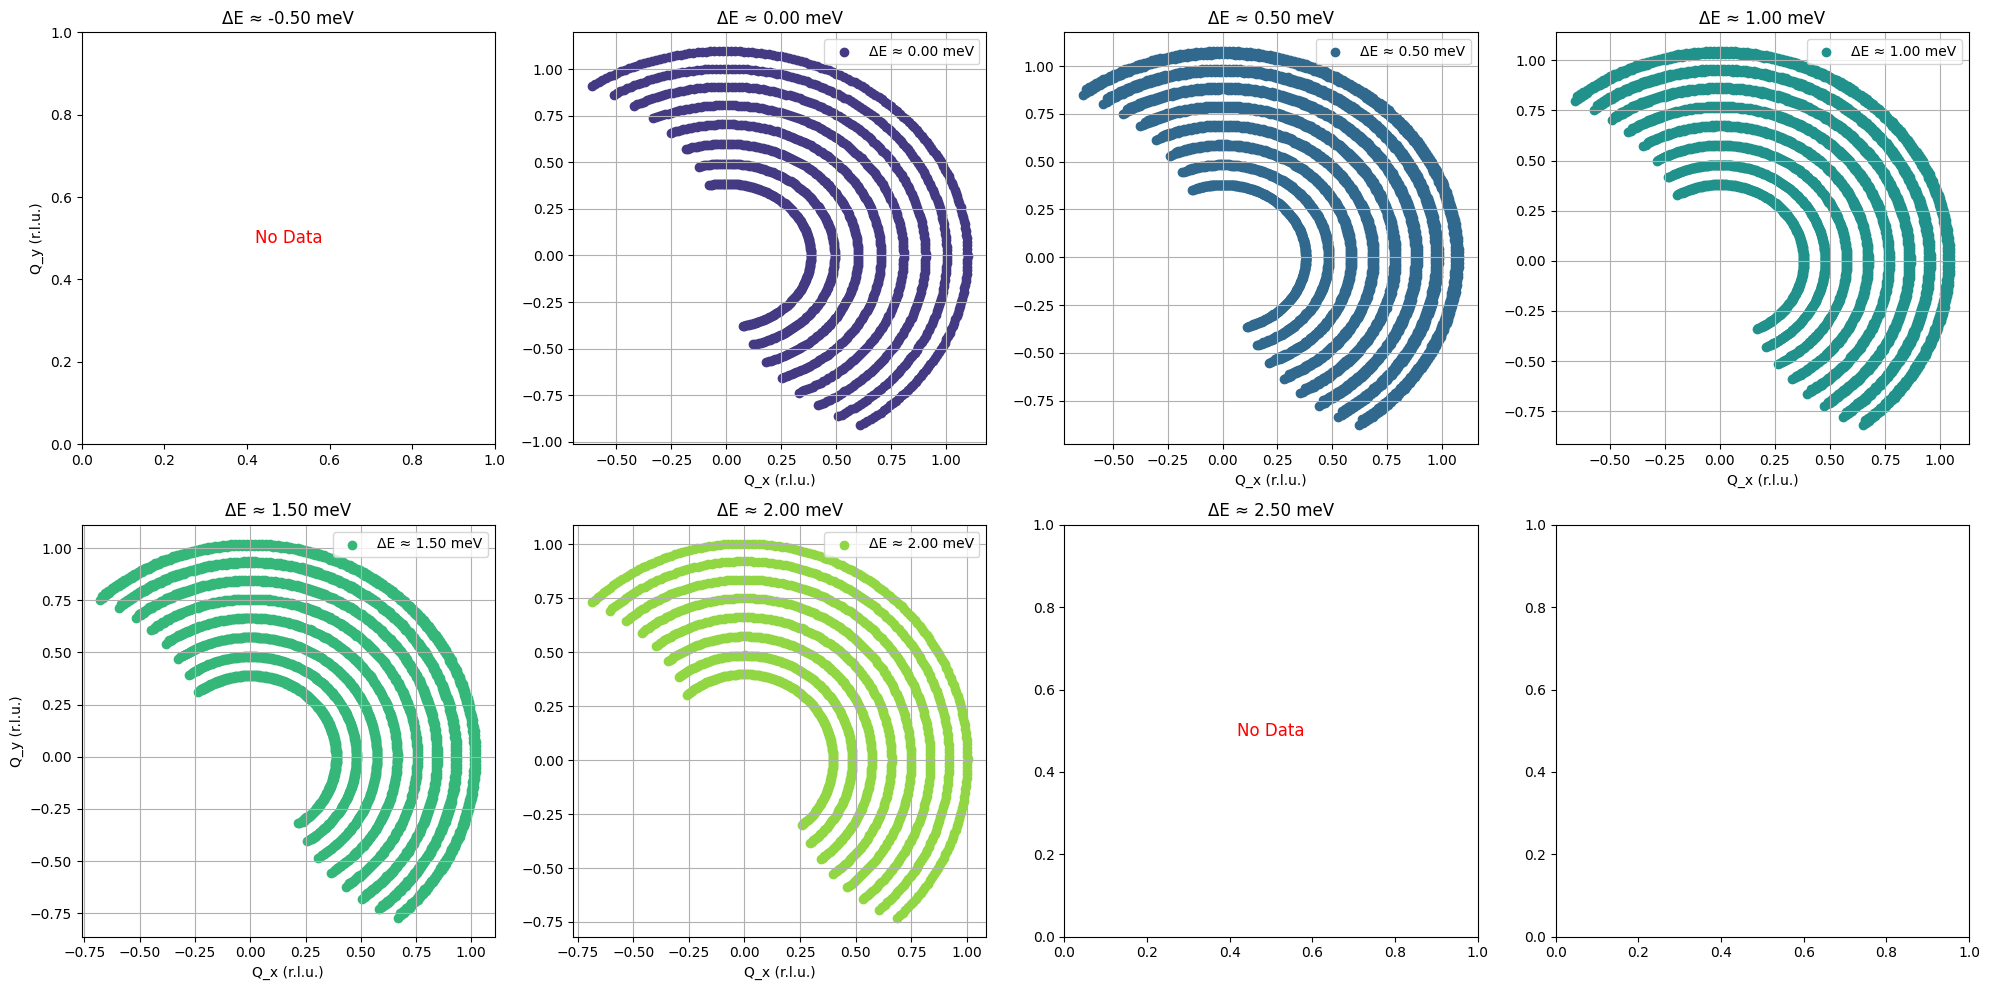

In [41]:

# Example parameters
a, b, c = 4.0, 4.0, 4.0  # Lattice parameters in Angstrom
alpha, beta, gamma = 90, 90, 90  # Lattice angles in degrees
E_i = 5.0  # Incoming energy in meV
detector_angles = [45-22.5,45+22.5]  # Detector angles in degrees
detector_angles = np.linspace(45-22.5,45+22.5,8)
sample_rotations = np.linspace(0,180,181)  # Sample rotation angles in degrees
# sample_rotations=[0]


reciprocal_lattice_vectors = calculate_reciprocal_lattice_vectors(a, b, c, alpha, beta, gamma)

results = []
for E_f in final_energies:
    for angle in detector_angles:
        Q_lab, delta_E = calculate_lab_Q_E(E_i, E_f, angle)
        for theta_S in sample_rotations:
            Q_rlu = convert_Q_to_sample_frame(Q_lab, theta_S, reciprocal_lattice_vectors)
            results.append((Q_rlu, delta_E))
            
# plot_3D(results)
# plot_constant_energy_2D(results, final_energies)  # The new 2D constant energy plots
plot_adjusted_energy_2D(results)



In [40]:
results[1]

(array([-0.02471765, -0.39701461, -0.09925365]), 1.7999999999999998)